# Fitting the Crate Data to the Thin Section Data

In this notebook, we attempt to apply the thin-section SVM classifier model (that was trained using automated-mineralogy) to the new crate data in a two step process:

1. __interpolate__ the spectrum from the crate images on the range overlapping the range of spectrum of the thin sections.
2. construct a __regression model__ that fits the overlapping region to the full range used by the SVM model.
    - Since our original SVM model uses PCA for dimensionality reduction, we can skip the dimensional lifting (going from the small overlapping range to the full range) and directly fit to the lower dimensional space which is a better posed model.
    - note that this step is achieved using the original thin-section data, an appropriate step would be to rescale the data (perhaps to zero mean and unit variance, as done here) in the hopes that this step accomodates the differences in scale between the two images.
    
![](plots/model_layout.png)
    
__variable naming convention:__ to specify variables related to thinsection data we label them `[what]_t[#]` where `[what]` refers to what the variable holds (e.g. `hypr` for hyperspectral absorbance, `wl` for wavelengths), and `[#]` is the cataloging number (e.g. 620). We follow a similar convension for the crate images replacing `t` with `c`, i.e. `[what]_c[#]`.

In [1]:
import spectral as sp
import spectral.io.envi as envi

import numpy as np
import scipy as sc

from scipy.interpolate import interp1d

import pandas as pd
import sklearn as sk
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import scale, StandardScaler, LabelEncoder
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.utils.multiclass import unique_labels

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import joblib

In [2]:
from source.hyperspectrum_models import Masker, LatentTransformer, LatentTransformer2

from source.plot_functions import plot_confusion, plot_predicted_mineralogy

In [3]:
np.random.seed(1234)
from tensorflow.random import set_seed
set_seed(1234)

In [4]:
img_c195 = envi.open("data/VNIR and SWIR interval/CMM-111_195_extracted_image.hdr", "data/VNIR and SWIR interval/CMM-111_195_extracted_image.img")
img_c196 = envi.open("data/VNIR and SWIR interval/CMM-111_196_extracted_image.hdr", "data/VNIR and SWIR interval/CMM-111_196_extracted_image.img")

In [5]:
wl_c = np.array( img_c195.bands.centers )
n_bands_c = img_c195.shape[-1]

hypr_c195 = img_c195.load()
print(f"crate image 195 shape: {hypr_c195.shape}")

masker = joblib.load('binaries/masker.joblib')
mask_c195 = masker(hypr_c195)
hypr_c195 = hypr_c195[mask_c195,:]

hypr_c195 = hypr_c195.reshape(-1, n_bands_c)

hypr_c196 = img_c196.load()
print(f"crate image 196 shape: {hypr_c196.shape}")

mask_c196 = masker(hypr_c196)
hypr_c196 = hypr_c196[mask_c196,:]

hypr_c196 = hypr_c196.reshape(-1, n_bands_c)

crate image 195 shape: (527, 337, 411)
crate image 196 shape: (525, 323, 411)


In [6]:
hypr_t = pd.read_pickle('data/original_data/hyper[16_17_20].pkl').values

In [7]:
n_bands_t = hypr_t.shape[-1]

wl_t = np.array( envi.open('data/original_data/324620.hdr', 'data/original_data/324620.dat').bands.centers )

In [8]:
wl_overlap_L = max( wl_c[0], wl_t[0] )
wl_overlap_U = min( wl_c[-1], wl_t[-1] )

## Multiple Input Model
the `LatentTransformer` class performs dimensionality using either PCA or an auto-encoder neural network on the thin section data. Then another model is constructed on the overlap region to indirectly approximate the full range. The model also interpolates the crate data on the overlapping range and rescales, so that the crate data can (hopefully) be used for the classification model.

In [9]:
help(LatentTransformer)

Help on class LatentTransformer in module source.hyperspectrum_models:

class LatentTransformer(builtins.object)
 |  LatentTransformer(overlap_range, n_components=8, model_type='SVD', **kwargs)
 |  
 |  This class transforms hyperspectral data from thin sections and crate images to a common
 |  latent variable usable for classifying both data types despite only having automated mineralogy
 |  labels for the thin sections.
 |      - overlap_range : tuple of length 2, lower and upper bounds for the wavelength range
 |          common to both data types.
 |      - n_components : dimension of latent variable.
 |      - model_type : "SVD", "AE", or "VAE", encoder type for latent model. "SVD" performs a linear
 |          dimensionality reduction by a truncated singular value decomposition, while
 |          "AE" performs a nonlinear dimensionality reduction using a neural network
 |          auto-encoder. "VAE" uses a variational auto-encoder.
 |  
 |  Methods defined here:
 |  
 |  __init_

In [10]:
n_comps = 6
mdl = LatentTransformer((wl_overlap_L, wl_overlap_U), n_components=n_comps, model_type='VAE')
mdl.fit(wl_c, hypr_c195, wl_t, hypr_t)

Epoch 1/200
77/77 [==============================] - 0s 4ms/step - loss: 0.2290
Epoch 2/200
77/77 [==============================] - 0s 4ms/step - loss: 0.0173
Epoch 3/200
77/77 [==============================] - 0s 4ms/step - loss: 0.0151
Epoch 4/200
77/77 [==============================] - 0s 4ms/step - loss: 0.0120
Epoch 5/200
77/77 [==============================] - 0s 4ms/step - loss: 0.0094
Epoch 6/200
77/77 [==============================] - 0s 4ms/step - loss: 0.0071
Epoch 7/200
77/77 [==============================] - 0s 4ms/step - loss: 0.0054
Epoch 8/200
77/77 [==============================] - 0s 4ms/step - loss: 0.0042
Epoch 9/200
77/77 [==============================] - 0s 4ms/step - loss: 0.0034
Epoch 10/200
77/77 [==============================] - 0s 5ms/step - loss: 0.0030
Epoch 11/200
77/77 [==============================] - 0s 4ms/step - loss: 0.0030
Epoch 12/200
77/77 [==============================] - 0s 4ms/step - loss: 0.0028
Epoch 13/200
77/77 [=================

In [13]:
joblib.dump(mdl, 'mdl.joblib')

PicklingError: Can't pickle <function LatentTransformer.__init__.<locals>.<lambda> at 0x7fc9284c2790>: it's not found as source.hyperspectrum_models.LatentTransformer.__init__.<locals>.<lambda>

In [11]:
latent_c195 = mdl.transform_c(hypr_c195)
latent_c196 = mdl.transform_c(hypr_c196)

## Distribution Comparison

Here we compare the distributions of the crate images and the thin-section images. We compare two crates to evaluate consistency accross that data type, and all of the thin-section data grouped together (which was used to construct the latent variable model).

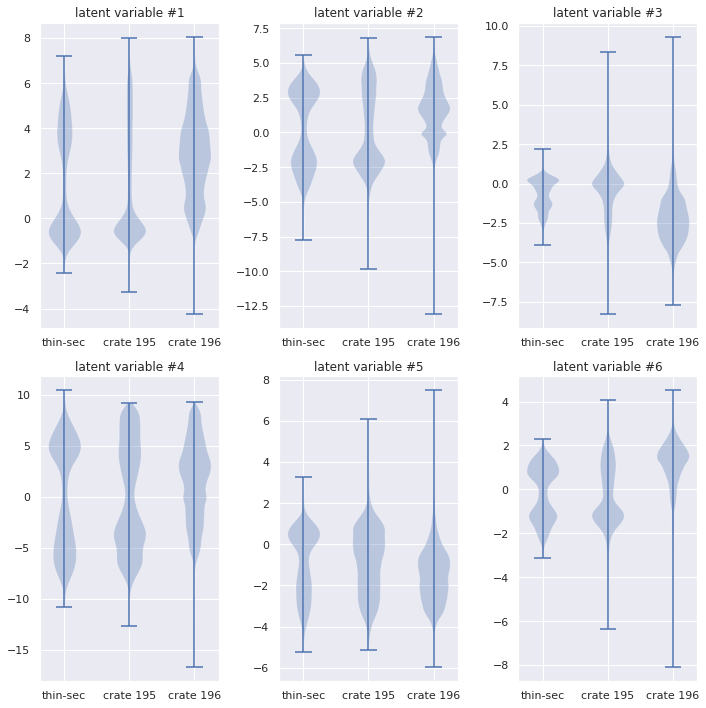

In [12]:
plt.figure(figsize=(10,10))

latent_t = mdl.transform_t(hypr_t)

for i in range(n_comps):
    plt.subplot(np.ceil(n_comps/3),3, i+1)
    plt.violinplot([
        latent_t[:,i],
        latent_c195[:,i],
        latent_c196[:,i]
    ])
    plt.xticks([1,2,3], ['thin-sec','crate 195', 'crate 196'])
    plt.title("latent variable #"+str(i+1))

plt.tight_layout()
plt.show()

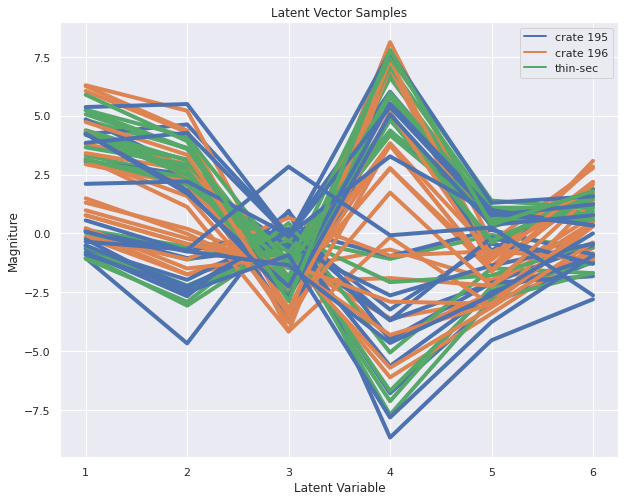

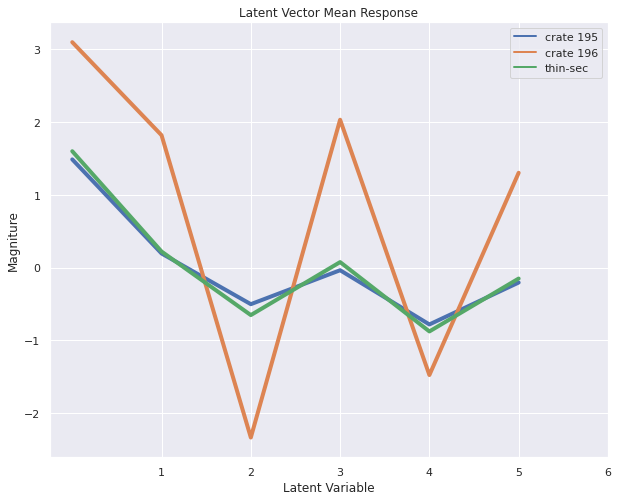

In [13]:
from matplotlib.lines import Line2D

lines = [Line2D([0], [0], color='C0', lw=2),
        Line2D([0], [0], color='C1', lw=2),
        Line2D([0], [0], color='C2', lw=2)]

nsamples = 20
df = pd.concat([pd.DataFrame(latent_c195).sample(nsamples),
               pd.DataFrame(latent_c196).sample(nsamples),
               pd.DataFrame(latent_t).sample(nsamples)], ignore_index=True)
labels = pd.concat([pd.Series(np.repeat('0', nsamples)),
                          pd.Series(np.repeat('1', nsamples)),
                          pd.Series(np.repeat('2', nsamples))], ignore_index=True)

I = np.random.permutation(nsamples*3)
df = df.values[I,:]
labels = ['C' + i for i in labels.values[I]]

plt.figure(figsize=(10,8))
for i in range(3*nsamples):
    plt.plot(np.arange(n_comps)+1, df[i,:], c=labels[i], lw=4)
plt.title('Latent Vector Samples')
plt.xlabel('Latent Variable')
plt.xticks(np.arange(n_comps)+1)
plt.ylabel('Magniture')
plt.legend(lines, ['crate 195', 'crate 196', 'thin-sec'])
plt.show()

plt.figure(figsize=(10,8))
mc195 = np.mean(latent_c195, axis=0); vc195 = np.std(latent_c195, axis=0)
plt.plot(mc195, c='C0', lw=4); #plt.plot(mc195-2*vc195, c='C0', lw=4, ls='--'); plt.plot(mc195+2*vc195, c='C0', lw=4, ls='--')

mc196 = np.mean(latent_c196, axis=0); vc196 = np.std(latent_c196, axis=0)
plt.plot(mc196, c='C1', lw=4); #plt.plot(mc196-2*vc196, c='C1', lw=4, ls='--'); plt.plot(mc196+2*vc196, c='C1', lw=4, ls='--')

mt = np.mean(latent_t, axis=0); vt = np.std(latent_t, axis=0)
plt.plot(mt, c='C2', lw=4); #plt.plot(mt-2*vt, c='C2', lw=4, ls='--'); plt.plot(mt+2*vt, c='C2', lw=4, ls='--')
plt.title('Latent Vector Mean Response')
plt.xlabel('Latent Variable')
plt.xticks(np.arange(n_comps)+1)
plt.ylabel('Magniture')
plt.legend(lines, ['crate 195', 'crate 196', 'thin-sec'])
plt.show()

## Classification

Here we fit a neural network with regularized activation. We determine the optimal regularization parameter by cross-validation tested on the macro $F_1$ score.

In [14]:
hypr_t620_training  = pd.read_pickle('data/original_data/324620_hypr_cleaned.pkl').values
minrl_t620_training = pd.read_pickle('data/original_data/324620_minrl_cleaned.pkl')
onehot_t620_training = minrl_t620_training.idxmax(axis=1)

X = pd.read_pickle('data/original_data/hyper[16_17_20].pkl').values
y = pd.read_pickle('data/original_data/mineral[16_17_20].pkl')
y.rename(columns={'Orthoclase':'K-Feldspar'}, inplace=True)
y = y.idxmax(axis=1)
LE = LabelEncoder()
LE.fit(y);

In [15]:
X = mdl.transform_t(X)

In [16]:
def scorer(estimator, x, y):
    yh = estimator.predict(x)
    return f1_score(y, yh, average='macro', zero_division=1)

cv = GridSearchCV(
    MLPClassifier(hidden_layer_sizes=(100,50,), activation='relu', max_iter=1000),
    {'alpha': np.logspace(-5,1,10)},
    cv=5,
    scoring=scorer,
    verbose=100
)

X_train, X_test, y_train, y_test = train_test_split(X, y)

cv.fit(X_train, y_train)

clf = cv.best_estimator_

print(f"best regularization parameter: {cv.best_params_}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] alpha=1e-05 .....................................................
[CV] ......................... alpha=1e-05, score=0.380, total=   3.5s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.5s remaining:    0.0s
[CV] alpha=1e-05 .....................................................
[CV] ......................... alpha=1e-05, score=0.374, total=   3.7s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.2s remaining:    0.0s
[CV] alpha=1e-05 .....................................................
[CV] ......................... alpha=1e-05, score=0.376, total=   2.9s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   10.1s remaining:    0.0s
[CV] alpha=1e-05 .....................................................
[CV] ......................... alpha=1e-05, score=0.378, total=   2.5s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapse

[CV] ........... alpha=0.46415888336127725, score=0.376, total=   6.2s
[Parallel(n_jobs=1)]: Done  37 out of  37 | elapsed:  2.1min remaining:    0.0s
[CV] alpha=0.46415888336127725 .......................................
[CV] ........... alpha=0.46415888336127725, score=0.363, total=   7.1s
[Parallel(n_jobs=1)]: Done  38 out of  38 | elapsed:  2.2min remaining:    0.0s
[CV] alpha=0.46415888336127725 .......................................
[CV] ........... alpha=0.46415888336127725, score=0.386, total=   5.5s
[Parallel(n_jobs=1)]: Done  39 out of  39 | elapsed:  2.3min remaining:    0.0s
[CV] alpha=0.46415888336127725 .......................................
[CV] ........... alpha=0.46415888336127725, score=0.384, total=   6.7s
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:  2.4min remaining:    0.0s
[CV] alpha=2.154434690031882 .........................................
[CV] ............. alpha=2.154434690031882, score=0.375, total=   5.7s
[Parallel(n_jobs=1)]: Done  41 out of  41

### Testing Results
The accuracy and confusion matrix reported are given according to testing data (still from the thin-sections).

accuracy: 0.7908616187989557


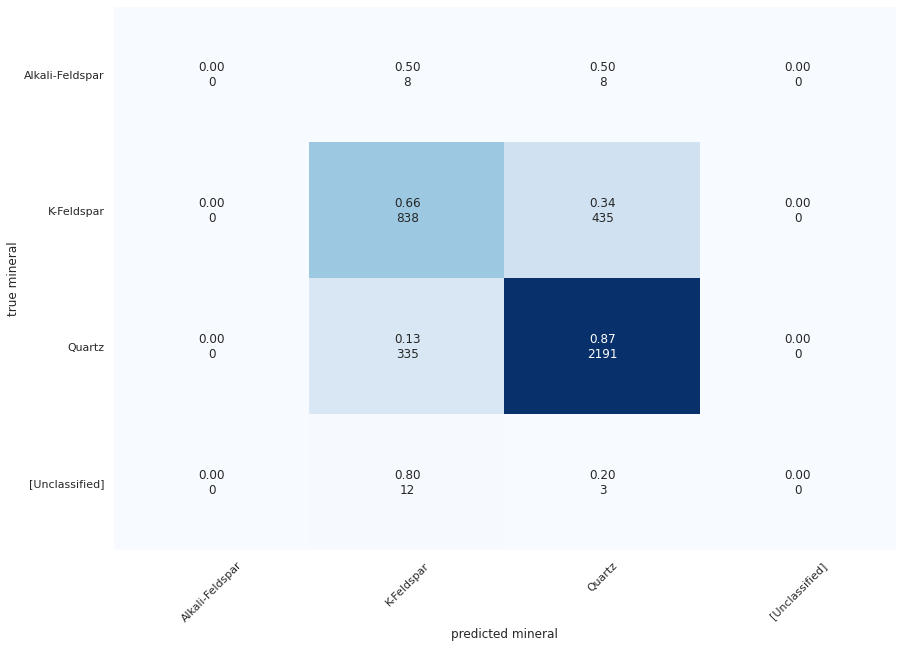

In [17]:
y_hat = clf.predict(X_test)
print(f"accuracy: {accuracy_score(y_test, y_hat)}")
plot_confusion(y_test, y_hat)

### Thin Section 620 Results
This was one of three images used to train the classifier.

In [18]:
yHat = clf.predict(mdl.transform_t(hypr_t620_training))

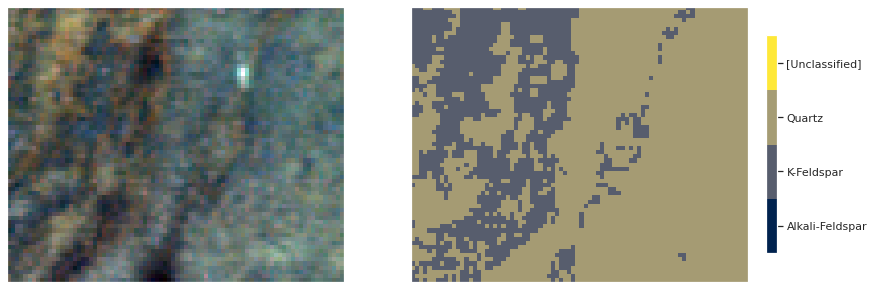

In [19]:
plot_predicted_mineralogy(
    sp.get_rgb(hypr_t620_training.reshape(67,82,214)),
    LE.transform(yHat).reshape(67,82),
    LE,
    figsize=(16,8))

### Crate 195 Results
This crate was used for the Latent variable model, but not for the classifier.

In [20]:
X = img_c195.load().reshape(-1, n_bands_c)
X = mdl.transform_c(X)
yHat = clf.predict(X)

yHat = LE.transform(yHat).reshape(527, 337)
yHat = np.array(yHat, dtype=float)
mask = masker(img_c195.load())
yHat[np.logical_not(mask)] = np.nan

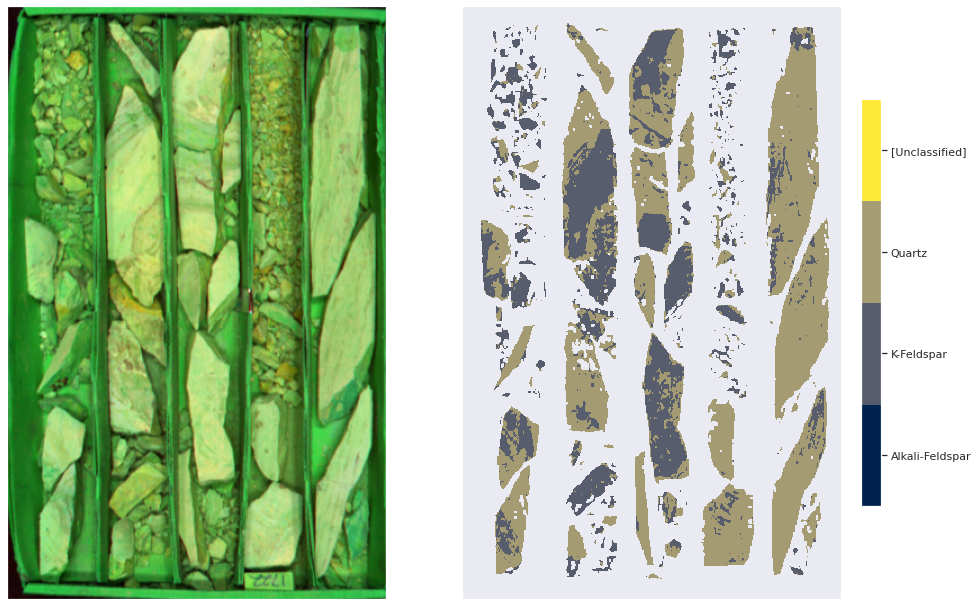

In [21]:
plot_predicted_mineralogy(
    sp.get_rgb(img_c195),
    yHat,
    LE,
    figsize=(18,15)
)

### Crate 196 results
This crate has not been seen by the Latent variable model, or the classifier.

In [22]:
mask = masker(img_c196.load())
shape_c196 = img_c196.shape[:2]
X = img_c196.load().reshape(-1, n_bands_c)

In [23]:
X = mdl.transform_c(X)
yHat = clf.predict(X)

yHat = LE.transform(yHat).reshape(shape_c196)
yHat = np.array(yHat, dtype=float)
yHat[np.logical_not(mask)] = np.nan

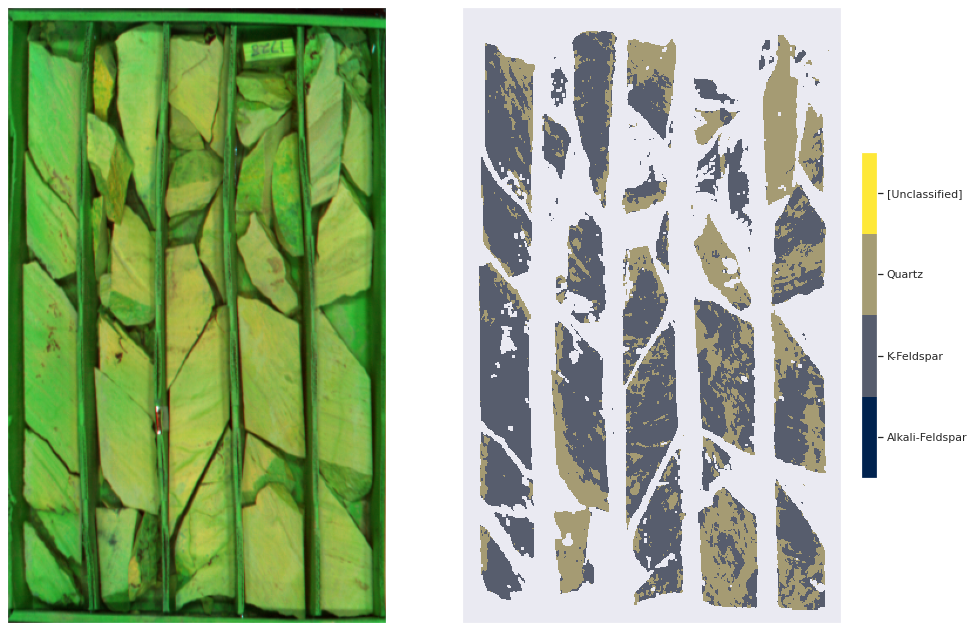

In [24]:
plot_predicted_mineralogy(
    sp.get_rgb(img_c196),
    yHat,
    LE,
    figsize=(18,12)
)